In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
ls -al

total 17652
drwxr-xr-x 3 jerome jerome    4096 nov.  12 14:26 ./
drwxr-xr-x 8 jerome jerome    4096 nov.  12 14:21 ../
-rw-r--r-- 1 jerome jerome      18 nov.  12 14:21 2017-11-04-12h29m25s.json
-rw-r--r-- 1 jerome jerome 7589376 nov.  12 14:21 2017-11-04-12h29m25s.yuv
-rw-r--r-- 1 jerome jerome 2469722 nov.  12 14:21 Grid_v3_1.jpg
-rw-r--r-- 1 jerome jerome 2470679 nov.  12 14:21 Grid_v3_2.jpg
-rw-r--r-- 1 jerome jerome 2472048 nov.  12 14:21 Grid_v3_3.jpg
-rw-r--r-- 1 jerome jerome  483933 nov.  12 14:26 Grid_v3.ipynb
drwxr-xr-x 2 jerome jerome    4096 nov.  12 14:22 .ipynb_checkpoints/
-rw-r--r-- 1 jerome jerome 2561442 nov.  12 14:21 wb_1_1.jpg


In [3]:
from PIL import Image
path = "Grid_v3_3.jpg"
raw = numpy.dot(numpy.asarray(Image.open(path)), [0.299,0.587, 0.114])
print(raw)

[[ 167.296  167.296  167.068 ...,  157.022  157.022  158.022]
 [ 167.068  166.068  166.068 ...,  157.022  159.022  158.022]
 [ 164.139  164.139  163.139 ...,  157.31   160.31   160.31 ]
 ..., 
 [ 170.274  170.274  167.915 ...,  141.368  135.895  133.194]
 [ 169.904  170.904  170.018 ...,  123.112  118.351  119.351]
 [ 170.904  168.904  169.018 ...,  116.041  115.992  114.992]]


<IPython.core.display.Javascript object>


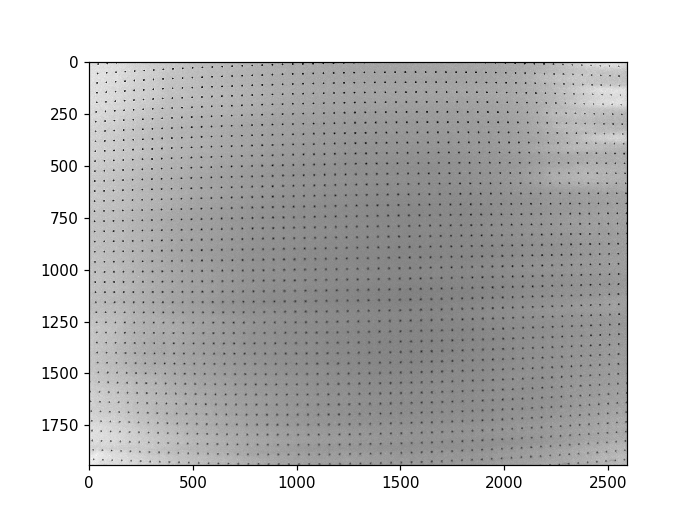

In [4]:
f, ax = subplots()
ax.imshow(raw, cmap="gray")

<IPython.core.display.Javascript object>


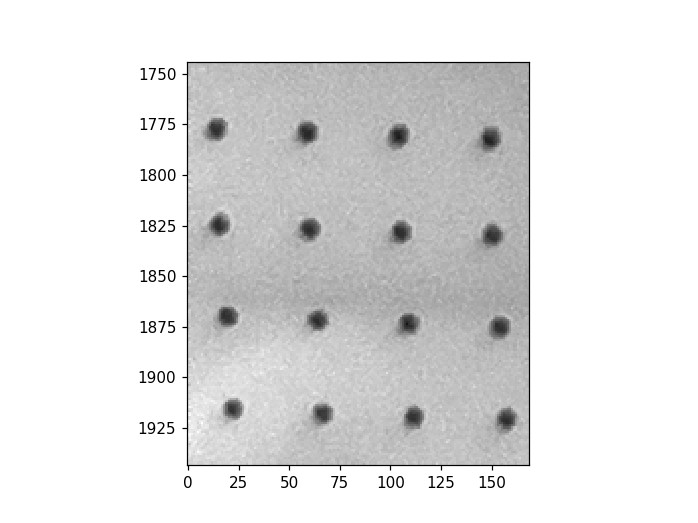

In [5]:
v = raw/255.0
m = (v > 0.04045)
raw_lin = numpy.empty_like(v)
raw_lin = v / 12.92
raw_lin[m] = (((v + 0.055) / 1.055) ** 2.4)[m]
f, ax = subplots()
ax.imshow(raw_lin, cmap="gray")

In [9]:
width=73

try:
    raise
    from silx.opencl import medfilt
    
except:
    print("using scipy")
    from scipy.ndimage import filters
    %time flat = filters.median_filter(raw, width, mode="nearest")                     
else:
    print("using silx")
    %time flat = medfilt.medfilt2d(raw, width)                     
#flat = filters.maximum_filter(raw, width, mode="nearest")   


using scipy
CPU times: user 3min 58s, sys: 88 ms, total: 3min 58s
Wall time: 3min 58s


<IPython.core.display.Javascript object>


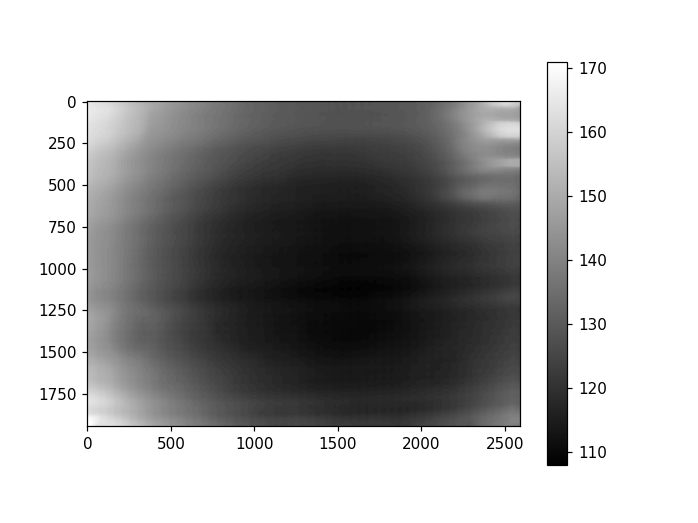

In [10]:
figure()
imshow(flat, cmap="gray")
colorbar()

<IPython.core.display.Javascript object>


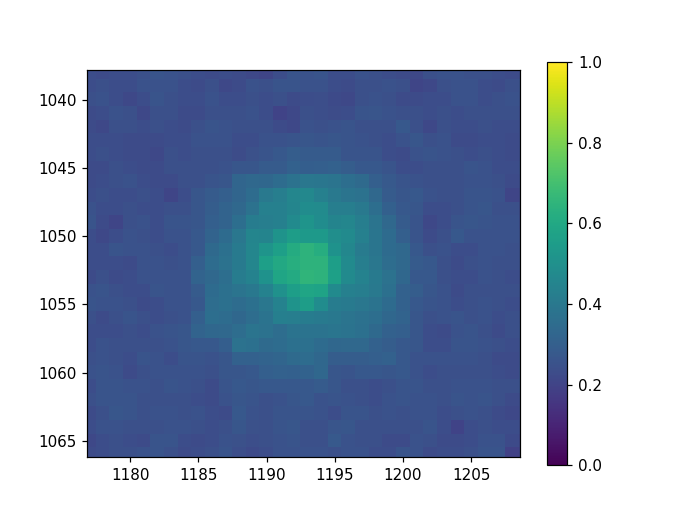

In [11]:
figure()
fcor = raw/flat
img = (fcor.max() - fcor)/(fcor.max()-fcor.min())
imshow(img)
colorbar()

<IPython.core.display.Javascript object>


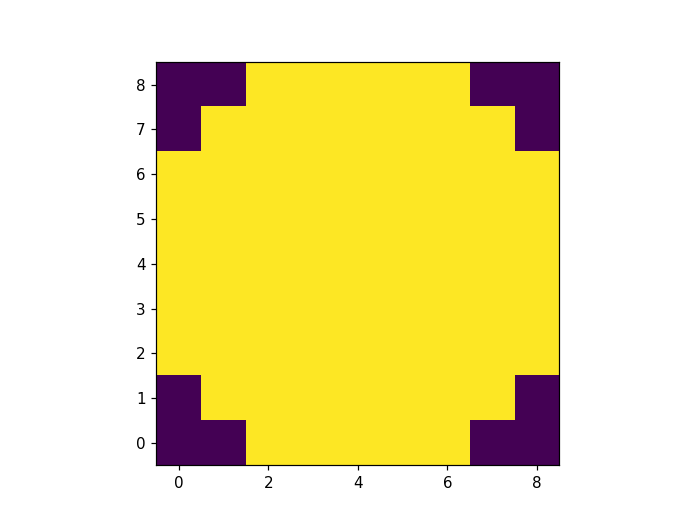

In [12]:
size = 9 #Odd of course
center = (size-1)//2
y, x = numpy.ogrid[-center:center+1,-center:center+1]
r2 = x*x + y*y
kernel = (r2<=(center+0.5)**2).astype(float)
kernel /= kernel.sum()
figure()
imshow(kernel, interpolation="nearest", origin="lower")

In [13]:
from scipy import ndimage, signal
cnv = signal.convolve2d(img, kernel, mode="same")

In [14]:
#Check that size is unchanged.
print(img.shape) 
print(cnv.shape)

(1944, 2592)
(1944, 2592)


<IPython.core.display.Javascript object>


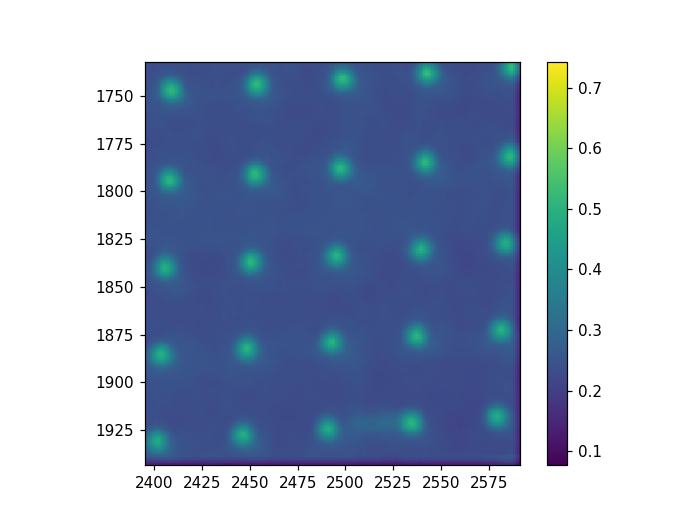

In [15]:
#Check the image still looks the same. it is just supposed to be smoother.
figure()
imshow(cnv, interpolation="nearest")
colorbar()

In [16]:
mini = (kernel>0).sum()
print("Number of points in the kernel: %s"%mini)

Number of points in the kernel: 69


In [18]:
try: #depends if the version of pyFAI you are using
    from pyFAI.watershed import InverseWatershed
except:
    from pyFAI.ext.watershed import InverseWatershed
    #Version of pyFAI newer than feb 2016
iw = InverseWatershed(cnv)
iw.init()
iw.merge_singleton()
all_regions = set(iw.regions.values())
regions = [i for i in all_regions if i.size>mini]

print("Number of region segmented: %s"%len(all_regions))
print("Number of large enough regions : %s"%len(regions))

Number of region segmented: 108109
Number of large enough regions : 11029


<IPython.core.display.Javascript object>


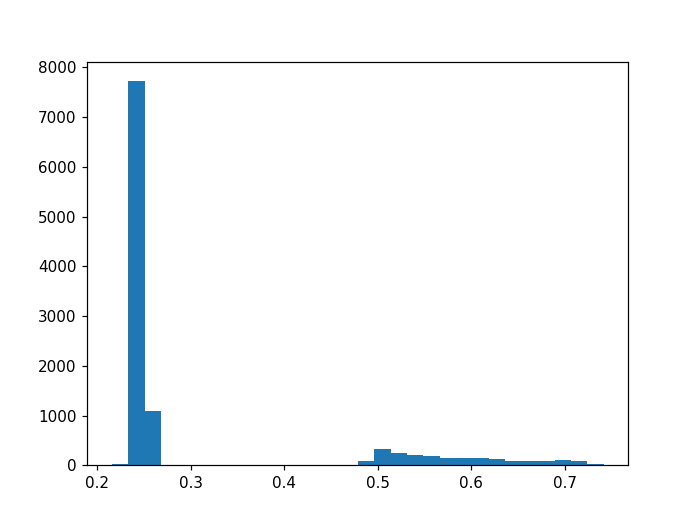

(array([  2.10000000e+01,   7.71600000e+03,   1.09500000e+03,
          1.40000000e+01,   6.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   3.00000000e+00,
          9.50000000e+01,   3.36000000e+02,   2.51000000e+02,
          2.04000000e+02,   1.94000000e+02,   1.55000000e+02,
          1.40000000e+02,   1.48000000e+02,   1.24000000e+02,
          8.00000000e+01,   9.70000000e+01,   9.80000000e+01,
          1.11000000e+02,   9.60000000e+01,   3.40000000e+01]),
 array([ 0.21537811,  0.23292623,  0.25047435,  0.26802247,  0.28557059,
         0.30311871,  0.32066683,  0.33821495,  0.35576307,  0.37331119,
         0.39085931,  0.40840743,  0.42595555,  0.44350367,  0.46105179,
         0.47859991,  0.49614803,  0.51369615,  0.53124427,  0.54879239,
         0.56634051,  0.58388863,  0.60143675,  0.61898487,  0.63653299,
         0.65

In [19]:
s = [i.maxi for i in regions]
figure()
hist(s, 30)
#Look for the maximum value in each region to be able to segment accordingly


In [20]:
thres= 0.4
peaks = [(i.index//img.shape[-1], i.index%img.shape[-1]) for i in regions if (i.maxi)>thres]
print("Number of remaining peaks: %s"%len(peaks))

Number of remaining peaks: 2169


<IPython.core.display.Javascript object>


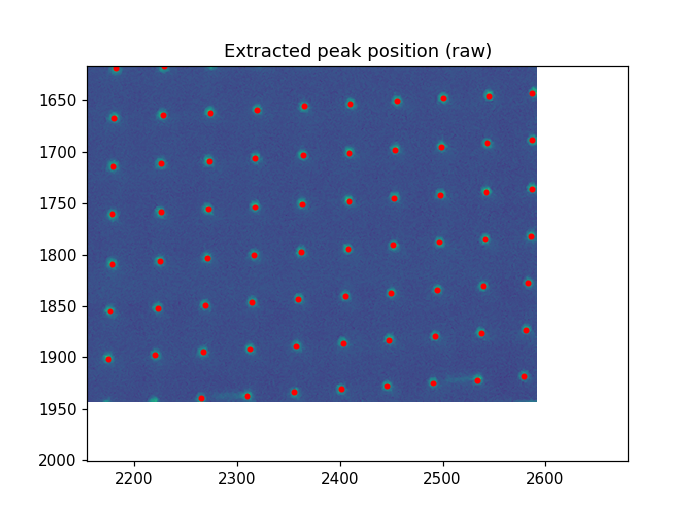

Raw peak coordinate:
[(407, 736), (610, 541), (1479, 2090), (1255, 1045), (1255, 1096), (1255, 1146), (817, 164), (1030, 2325), (611, 493), (1256, 995)]


In [21]:
figure()
imshow(img, interpolation="nearest")
peaks_raw = numpy.array(peaks)
plot(peaks_raw[:,1], peaks_raw[:, 0], ".r")
title("Extracted peak position (raw)")
print("Raw peak coordinate:")
print(peaks[:10])

In [22]:
try:
    from pyFAI.bilinear import Bilinear
except:
    from pyFAI.ext.bilinear import Bilinear
bl = Bilinear(cnv)

<IPython.core.display.Javascript object>


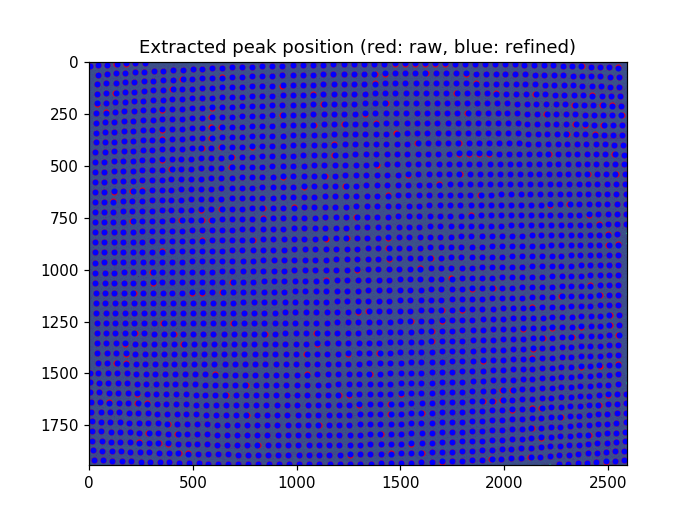

Refined peak coordinate:
[(407.19720862805843, 735.894225731492), (610.1827802062035, 540.9549306966364), (1479.0811512470245, 2089.757886096835), (1255.4191046357155, 1045.034220263362), (1254.974190423265, 1095.4199246764183), (1254.595869421959, 1145.989628907293), (816.8750995770097, 163.80051277577877), (1029.5523448586464, 2324.598742991686), (611.3941236436367, 492.72202518582344), (1256.1513637900352, 995.0366613529623)]


In [23]:
figure()
ref_peaks = [bl.local_maxi(p) for p in peaks_raw]
imshow(img, interpolation="nearest")
peaks_ref = numpy.array(ref_peaks)
plot(peaks_raw[:,1], peaks_raw[:, 0], ".r")
plot(peaks_ref[:,1],peaks_ref[:, 0], ".b")
title("Extracted peak position (red: raw, blue: refined)")
print("Refined peak coordinate:")
print(ref_peaks[:10])

In [24]:
# Nota, pyFAI uses **C-coordinates** so they come out as (y,x) and not the usual (x,y). 
# This notation helps us to remind the order
yx = numpy.array(ref_peaks)

In [25]:
# pairwise distance calculation using scipy.spatial.distance_matrix
from scipy.spatial import distance_matrix
dist = distance_matrix(peaks_ref, peaks_ref)

<IPython.core.display.Javascript object>


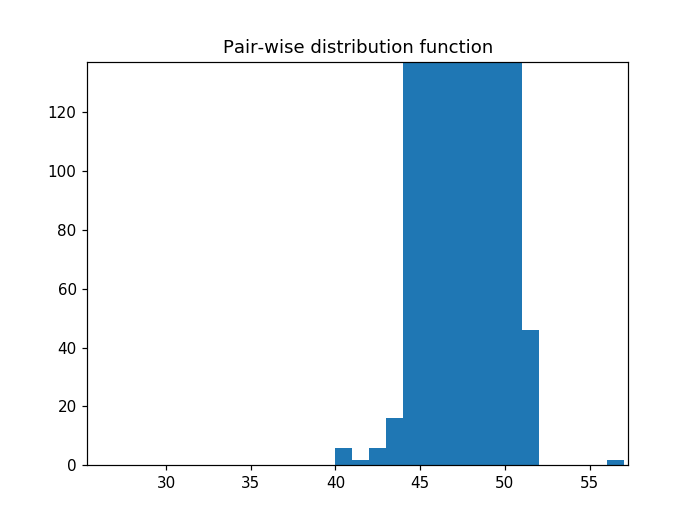

In [26]:
figure()
hist(dist.ravel(), 200, range=(0,200))
title("Pair-wise distribution function")

In [27]:
#We define here a data-type for each peak (called center) with 4 neighbours (called north, east, south and west). 
point_type = np.dtype([('center_y', float), ('center_x', float),
                        ('east_y', float), ('east_x', float),
                        ('west_y', float), ('west_x', float),
                        ('north_y', float), ('north_x', float),
                        ('south_y', float), ('south_x', float)])

neig = np.logical_and(dist>10.0, dist<55)
valid = (neig.sum(axis=-1)==4).sum()
print("There are %i control point with exactly 4 first neigbours"%valid)
# This initializes an empty structure to be populated
point = numpy.zeros(valid, point_type)

There are 1981 control point with exactly 4 first neigbours


In [28]:
#Populate the structure: we use a loop as it loops only over 1200 points 
h=-1
for i, center in enumerate(peaks_ref):
    if neig[i].sum()!=4: continue
    h+=1
    point[h]["center_y"],point[h]["center_x"] = center
    for j in ((0,1),(0,-1),(1,0),(-1,0)):
        tmp = []
        for k in numpy.where(neig[i]):
            curr = yx[k]
            tmp.append(dot(curr-center,j))
            l = argmax(tmp)
            y, x = peaks_ref[numpy.where(neig[i])][l]
            if j==(0,1):point[h]["east_y"], point[h]["east_x"] = y, x
            elif j==(0,-1):point[h]["west_y"], point[h]["west_x"] = y, x
            elif j==(1,0): point[h]["north_y"],point[h]["north_x"] = y, x
            elif j==(-1,0):point[h]["south_y"],point[h]["south_x"] = y, x
all_points = point

<IPython.core.display.Javascript object>


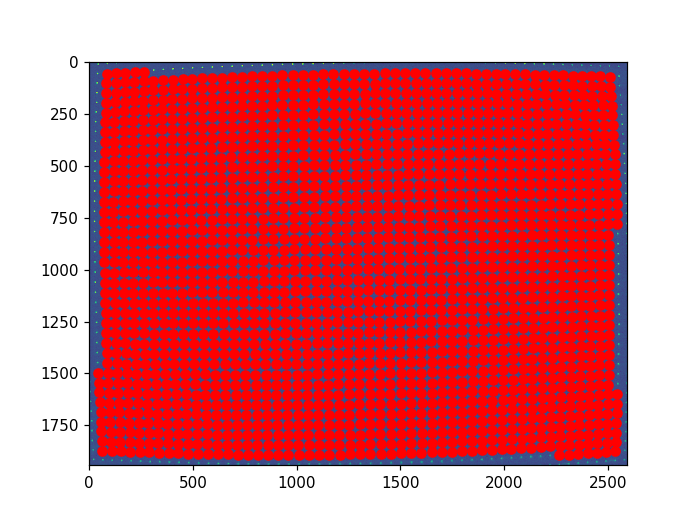

In [29]:
figure()
ref_peaks = [bl.local_maxi(p) for p in peaks_raw]
imshow(img, interpolation="nearest")
#peaks_ref = numpy.array(ref_peaks)
plot(point[:]["center_x"], point[:]["center_y"], "or")


The guessed center is at (1296, 972)
1274


<IPython.core.display.Javascript object>


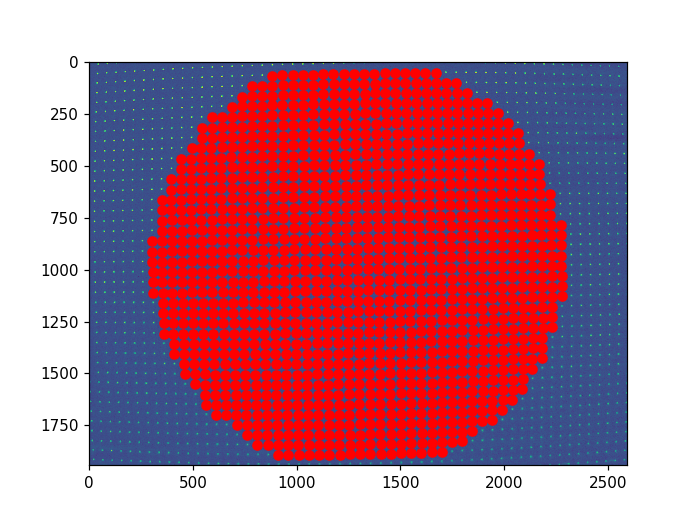

In [32]:
Cy, Cx = tuple(i//2 for i in cnv.shape) #detector center
print("The guessed center is at (%s, %s)"%(Cx, Cy))

t2 = 1000**2
point_mask = numpy.array([(i["center_x"]-Cx)**2+ (i["center_y"]-Cy)**2<t2 for i in point])
print(point_mask.sum())
figure()
ref_peaks = [bl.local_maxi(p) for p in peaks_raw]
imshow(img, interpolation="nearest")
point = point[point_mask]
plot(point[:]["center_x"], point[:]["center_y"], "or")


In [33]:
#Select the initial guess for the center:

#Most intense peak:
#m = max([i for i in regions], key=lambda i:i.maxi)
#Cx, Cy = m.index%img.shape[-1],m.index//img.shape[-1]
#Cx, Cy = point["center_x"].mean(), point["center_y"].mean() #Centroid of all points
#Cx, Cy = 734, 1181 #beam center
Cy, Cx = tuple(i//2 for i in cnv.shape) #detector center
print("The guessed center is at (%s, %s)"%(Cx, Cy))

#Get the nearest point from centroid:
d2 = ((point["center_x"]-Cx)**2+(point["center_y"]-Cy)**2)
best = d2.argmin()
Op = point[best]
Ox, Oy = Op["center_x"], Op["center_y"]

print("The center is at (%s, %s)"%(Ox, Oy))
#Calculate the average vector along the 4 main axes 
Xx = (point[:]["east_x"] - point[:]["center_x"]).mean()
Xy = (point[:]["east_y"] - point[:]["center_y"]).mean()
Yx = (point[:]["north_x"] - point[:]["center_x"]).mean()
Yy = (point[:]["north_y"] - point[:]["center_y"]).mean()

print("The X vector is is at (%s, %s)"%(Xx, Xy))
print("The Y vector is is at (%s, %s)"%(Yx, Yy))


The guessed center is at (1296, 972)
The center is at (1292.55036265, 948.657048285)
The X vector is is at (49.2287110281, -0.775755702456)
The Y vector is is at (0.787159085701, 49.3862739346)


In [34]:
print("X has an angle of %s deg"%rad2deg(arctan2(Xy, Xx)))
print("Y has an angle of %s deg"%rad2deg(arctan2(Yy, Yx)))
print("The XY angle is %s deg"%rad2deg(arctan2(Yy, Yx)-arctan2(Xy, Xx)))

X has an angle of -0.902803429595 deg
Y has an angle of 89.0868500259 deg
The XY angle is 89.9896534555 deg


In [35]:
from collections import namedtuple, OrderedDict
Peak = namedtuple("Peak", ('center_y', 'center_x'))
Coord = namedtuple("Coord", ('X', 'Y'))
dicopt = OrderedDict()

def nearest(pty,ptx):
    d2 = (point[:]['center_y']-pty)**2 +  (point[:]['center_x']-ptx)**2
    m = d2.argmin()
    if d2[m]<1:
        return point[m]

def add_nei(pt, coord):
    dicopt[coord]= Peak(pt[0],pt[1])
    east = nearest(pt[2],pt[3])
    east_coord = Coord(coord[0]+1, coord[1])
    if east is not None:
        if east_coord not in dicopt:
            add_nei(east, east_coord)
    else:
        dicopt[east_coord] = Peak(pt[2],pt[3])

    west = nearest(pt[4],pt[5])
    west_coord = Coord(coord[0]-1, coord[1])
    if west is not None:
        if west_coord not in dicopt:
            add_nei(west, west_coord)
    else:
        dicopt[west_coord] = Peak(pt[4],pt[5])

    south = nearest(pt[6],pt[7])
    south_coord = Coord(coord[0], coord[1]+1)
    if south is not None:
        if south_coord not in dicopt:
            add_nei(south, south_coord)
    else:
        dicopt[south_coord] = Peak(pt[6],pt[7])

    north = nearest(pt[8],pt[9])
    north_coord = Coord(coord[0], coord[1]-1)
    if north is not None:
        if north_coord not in dicopt:
            add_nei(north, north_coord)
    else:
        dicopt[north_coord] = Peak(pt[8],pt[9])


add_nei(Op, Coord(0,0))
print(len(dicopt))

1392


In [36]:
dataset = numpy.zeros((len(dicopt), 4))
for idx, (k,v) in enumerate(dicopt.items()):
    if idx<10:
        print("%s --> %s"%(k,v))
    dataset[idx,0] = k[0]
    dataset[idx,1] = k[1]
    dataset[idx,2] = v[1]
    dataset[idx,3] = v[0]
print(dataset[:5])

Coord(X=0, Y=0) --> Peak(center_y=948.65704828500748, center_x=1292.5503626465797)
Coord(X=1, Y=0) --> Peak(center_y=947.82085710763931, center_x=1343.3348197340965)
Coord(X=2, Y=0) --> Peak(center_y=946.75308249890804, center_x=1393.499279499054)
Coord(X=3, Y=0) --> Peak(center_y=945.92782516032457, center_x=1444.2136210054159)
Coord(X=4, Y=0) --> Peak(center_y=945.14263954758644, center_x=1494.6876991391182)
Coord(X=5, Y=0) --> Peak(center_y=944.53676787018776, center_x=1545.463967949152)
Coord(X=6, Y=0) --> Peak(center_y=943.64880988001823, center_x=1595.555840909481)
Coord(X=7, Y=0) --> Peak(center_y=942.75522230565548, center_x=1645.4988499879837)
Coord(X=8, Y=0) --> Peak(center_y=941.85663470625877, center_x=1695.5342879295349)
Coord(X=9, Y=0) --> Peak(center_y=941.09496000409126, center_x=1745.663125962019)
[[  0.00000000e+00   0.00000000e+00   1.29255036e+03   9.48657048e+02]
 [  1.00000000e+00   0.00000000e+00   1.34333482e+03   9.47820857e+02]
 [  2.00000000e+00   0.00000000e

In [37]:
def rotate(arg, data=dataset): 
    "Convert the XY (integrers) parameters in xy, pixel coordinates, without distortion, only rotation+translation"
    xc, yc, Xx, Yx, Xy, Yy, Xc, Yc = arg
    XYc = numpy.atleast_2d(numpy.array((Xc, Yc)))
    XY = (data[:,:2]-XYc).T
    #R = numpy.array([[Xx, Xy],[Yx, Yy]])
    R = numpy.array([[Xx, Yx], [Xy, Yy]])
    xyc = numpy.atleast_2d(numpy.array((xc, yc)))
    res = dot(R, XY).T + xyc
    return res 

def error_rot(arg, data=dataset):
    w = rotate(arg, data=data) 
    e = data[:,2:]
    d2 = (w-e)**2
    return numpy.sum(d2)

w = rotate([Ox, Oy, Xx, Yx, Xy, Yy, 0, 0], dataset) 
for i in range(5):
    print("%s %s "%(dataset[i,:], w[i,:]))

#mask = numpy.where(numpy.logical_and(abs(dataset[:,0])<5, abs(dataset[:,1])<5))
#print(mask[0], len(mask[0]))
#for i in mask[0]:
#    print(w[i], dataset[i,2:], ((w[i]-dataset[i,2:])**2).sum())
print(((w-dataset[:,2:])**2).sum())

print(error_rot((Ox, Oy, Xx,Yx, Xy, Yy, 0, 0)))
    
from scipy.optimize import minimize
res0 = [Ox, Oy, Xx, Yx, Xy, Yy, 0, 0]
print(res0)
bounds = [(1000,1500),(800, 1200), (40,60), (-5, 5), (-5, 5), (40,60), 
          (-10, 10),(-10, 10)]
print(res0)
print(error_rot(res0))
res1  = minimize(error_rot, res0, bounds=bounds)
print(res1)
res1 = res1.x

[    0.             0.          1292.55036265   948.65704829] [ 1292.55036265   948.65704829] 
[  1.00000000e+00   0.00000000e+00   1.34333482e+03   9.47820857e+02] [ 1341.77907367   947.88129258] 
[    2.            0.         1393.4992795   946.7530825] [ 1391.0077847    947.10553688] 
[    3.             0.          1444.21362101   945.92782516] [ 1440.23649573   946.32978118] 
[    4.             0.          1494.68769914   945.14263955] [ 1489.46520676   945.55402548] 
85153.8634511
85153.8634511
[1292.5503626465797, 948.65704828500748, 49.22871102812735, 0.78715908570102533, -0.77575570245578984, 49.386273934649161, 0, 0]
[1292.5503626465797, 948.65704828500748, 49.22871102812735, 0.78715908570102533, -0.77575570245578984, 49.386273934649161, 0, 0]
85153.8634511
      fun: 40055.766772460178
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01091394, -0.02182787, -0.36816346,  0.18480932, -0.15643309,
        0.1193257 , -0.53842086,  0.91822585])
  mes

In [38]:
from scipy.optimize import minimize

def wrapd1(arg, data=dataset):
    d = data[:,2:]
    
    c = numpy.atleast_2d(numpy.array((arg[0], arg[1])))
    r1 =((d - c)**2).sum(axis=-1)
    r2 = numpy.atleast_2d(r1).T
    #for i in zip(dataset, r2, range(10)):
    #    print(i[0], i[1])
    K1 = arg[8]*1e-9
    return c + (d-c)/(1.0+K1*r2)

def unwrapd1(arg, data=dataset):
    "convert indexes to distorted position"
    u = rotate(arg[:8], data=data) 
    c = numpy.atleast_2d(numpy.array((arg[0], arg[1])))
    r1 =((u - c)**2).sum(axis=-1)
    r2 = numpy.atleast_2d(r1).T
    #for i in zip(dataset, r2, range(10)):
    #    print(i[0], i[1])
    K1 = arg[8]*1e-9
    return c + (u - c)*(1+K1*r2)
    #return c + (d-c)/(1.0+K1*r2)


def errord1(arg, data=dataset):
    w = wrapd1(arg, data=data) 
    u = rotate(arg[:8]) 
    d2 = (w-u)**2
    return numpy.sum(d2)

def errord1u(arg, data=dataset):
    ex = unwrapd1(arg, data=data) 
    di = data[:,2:]
    d2 = (ex-di)**2
    return numpy.sum(d2)


res0d1=list(res1)+[0]
print(errord1(res0d1))

boundsd1 = [(i,i) for i in res1] + [(-10,10)]

#Does not work very well
res1d1  = minimize(errord1, res0d1, bounds=boundsd1)
print(res1d1)

res1d1u  = minimize(errord1u, res0d1, bounds=boundsd1)
print(res1d1u)

bounds2d1 = bounds + [(-100,100)]
print(len(bounds2d1), len(res1d1.x))

res2d1  = minimize(errord1, res1d1.x, bounds=bounds2d1)
print(res2d1)

res2d1u  = minimize(errord1u, res1d1u.x, bounds=bounds2d1)
print(res2d1u)

#bounds[6] = res1[6], res1[6]
#bounds[7] = res1[7], res1[7]
#bounds[11] = -1.1,1.1
#bounds[10] = -1.1,1.1
#print(errord1(res1d1.x))
#res2  = minimize(error, res1, bounds=bounds)
#print(res2)

40055.7667725
      fun: 36020.422797482905
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -6.33815944e+01,  -2.32412276e+02,  -3.50149807e+04,
        -5.63890353e+02,   4.95435961e+02,  -3.18853170e+04,
         3.22287888e+03,   1.15869560e+04,   5.09317033e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 50
      nit: 3
   status: 0
  success: True
        x: array([  1.28890217e+03,   9.46804318e+02,   4.96067035e+01,
         7.99303980e-01,  -7.76553690e-01,   4.97588120e+01,
        -5.35333534e-02,  -2.39820928e-02,  -2.98698939e+00])
      fun: 35712.369834572331
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -7.62600394e+01,  -2.38800567e+02,  -3.61293496e+04,
        -6.03000080e+02,   4.90730599e+02,  -3.28861010e+04,
         3.86553147e+03,   1.19161610e+04,   1.45519152e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 50
      nit: 2
   status: 0
  success

<IPython.core.display.Javascript object>


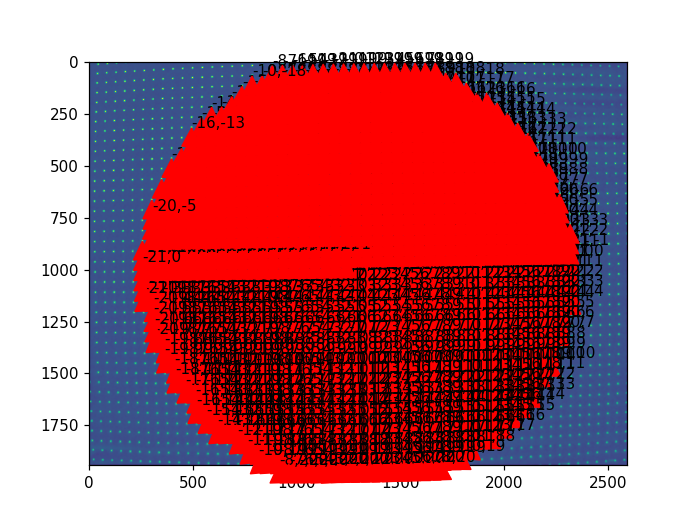

In [39]:
fitted = unwrapd1(res2d1u.x)
f = figure()
ax = f.add_subplot(1,1,1)
ax.imshow(cnv, interpolation="nearest")
for k, ds, w in zip(dicopt, dataset, fitted):
    ax.annotate("%i,%i"%k, xy=ds[2:], xytext=w,
                arrowprops=dict(facecolor='red', edgecolor='red'))

729
1392 729


<IPython.core.display.Javascript object>


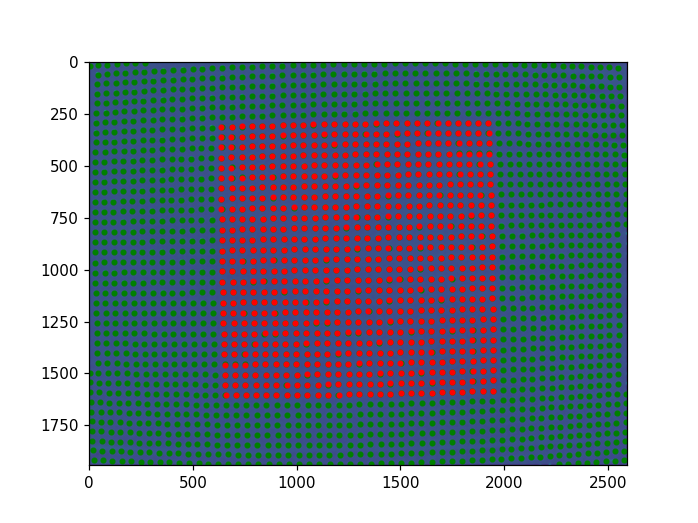

In [40]:
import itertools
all_idx_12 = numpy.array(list(itertools.product(range(-13, 14),range(-13,14))),dtype="float64")
print(len(all_idx_12))
fitted_12 = unwrapd1(res2d1u.x, data=all_idx_12)
print(len(dataset), len(fitted_12))
f,ax = subplots()
ax.imshow(cnv, interpolation="nearest")
plot(peaks_ref[:,1],peaks_ref[:, 0], ".g")
plot(fitted_12[:,0], fitted_12[:,1],".r")

(729, 2169)
729
252.109079928
0 [ -13.          -13.          638.61407107  312.66201174] [ 637.90959819  313.05126425]
1 [ -13.          -12.          638.58003035  361.56456336] [ 637.61938238  361.63179145]
2 [ -13.          -11.          638.33031717  410.27802244] [ 637.41688984  410.45936247]
3 [ -13.          -10.          637.87677529  459.22468382] [ 637.30179562  459.51378042]
4 [ -13.           -9.          637.77231109  508.39604482] [ 637.27377476  508.77484842]
5 [ -13.           -8.          637.82216513  557.98674074] [ 637.3325023   558.22236957]
6 [ -13.           -7.          638.07948551  607.52810043] [ 637.47765328  607.83614699]
7 [ -13.           -6.          638.03285109  657.21211024] [ 637.70890274  657.59598377]
8 [ -13.           -5.          638.4923186   707.07740752] [ 638.02592574  707.48168303]
9 [ -13.           -4.          639.0217843   757.35690886] [ 638.4283973   757.47304788]


<IPython.core.display.Javascript object>


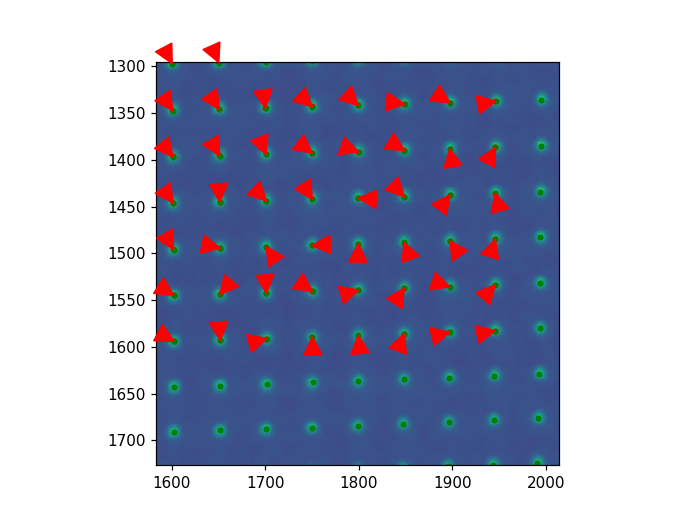

In [41]:
from scipy.spatial.distance import cdist
peaks_ref_xy = numpy.zeros_like(peaks_ref)
peaks_ref_xy[:,0] = peaks_ref[:,1]
peaks_ref_xy[:,1] = peaks_ref[:,0]
all_dist_12 = cdist(fitted_12, peaks_ref_xy,  'euclidean')
print(all_dist_12.shape)
dmin = all_dist_12.min(axis=1)
amin = all_dist_12.argmin(axis=1)
msk = dmin<40
print(msk.sum())
dataset_12 = numpy.zeros((msk.sum(), 4))
dataset_12[:,:2] = all_idx_12[msk]
dataset_12[:,2:] = peaks_ref_xy[amin[msk]]

# def unwrapd2(arg, data=dataset):
#     "convert indexes to distorted position"
#     u = rotate(arg[:8], data=data) 
#     c = numpy.atleast_2d(numpy.array((arg[0], arg[1])))
#     r1 =((u - c)**2).sum(axis=-1)
#     r2 = numpy.atleast_2d(r1).T
#     #for i in zip(dataset, r2, range(10)):
#     #    print(i[0], i[1])
#     K1 = arg[8]*1e-9
#     K2 = arg[9]*1e-12
#     return c + (u - c)*(1+K1*r2+K2*r2*r2)


# def errord2u(arg, data=dataset):
#     ex = unwrapd2(arg, data=data) 
#     di = data[:,2:]
#     d2 = (ex-di)**2
#     return numpy.sum(d2)


print(errord1u(list(res2d1u.x), data=dataset_12))
# fitted_12 = unwrapd1(list(res2d1u.x), data=dataset_12)
for i in zip(range(10), dataset_12, fitted_12):
        print(i[0], i[1], i[2])
f,ax = subplots()
ax.imshow(cnv, interpolation="nearest")
plot(fitted_12[:,0], fitted_12[:,1],".r")
plot(peaks_ref_xy[:,0],peaks_ref_xy[:, 1], ".g")
for ds, w in zip(dataset_12, fitted_12):
    ax.annotate("", xy=ds[2:], xytext=w,
                arrowprops=dict(facecolor='red', edgecolor='red'))



[[  637.90959819   313.05126425]
 [  637.61938238   361.63179145]
 [  637.41688984   410.45936247]
 ..., 
 [ 1945.76173321  1485.10566853]
 [ 1945.52856322  1533.97675904]
 [ 1945.20069482  1582.61273563]]
252.109079928
      fun: 157.51869735787207
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.12180692,  0.07507595, -0.03919354, -0.24245139, -0.0280437 ,
       -0.02845866,  0.1763766 ,  0.04671392, -0.07809717,  0.09123369])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1221
      nit: 105
   status: 0
  success: True
        x: array([  1.26639358e+03,   9.61006678e+02,   5.06482366e+01,
         8.20385243e-01,  -7.89105638e-01,   5.07831552e+01,
        -5.20352777e-01,   2.46273717e-01,  -2.77824371e+01,
         8.79837200e-01])


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


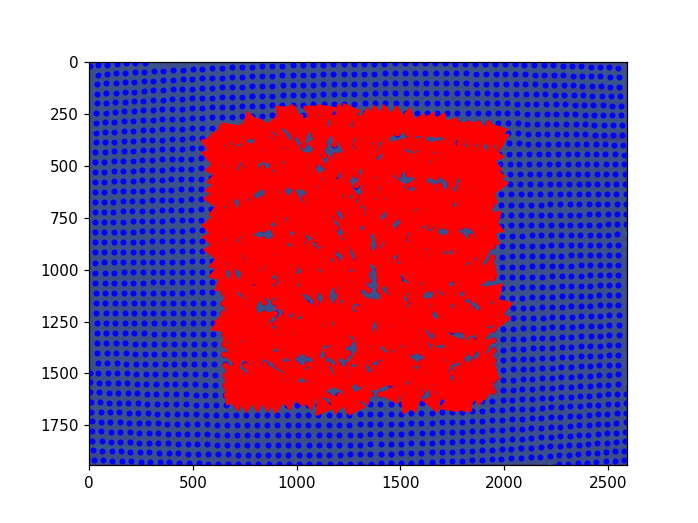

In [49]:
def unwrapd2(arg, data=dataset):
    "convert indexes to distorted position"
    u = rotate(arg[:8], data=data) 
    c = numpy.atleast_2d(numpy.array((arg[0], arg[1])))
    r1 =((u - c)**2).sum(axis=-1)
    r2 = numpy.atleast_2d(r1).T
    #for i in zip(dataset, r2, range(10)):
    #    print(i[0], i[1])
    K1 = arg[8]*1e-9
    K2 = arg[9]*1e-15
    return c + (u - c)*(1+K1*r2+K2*r2*r2)


def errord2u(arg, data=dataset):
    ex = unwrapd2(arg, data=data) 
    di = data[:,2:]
    d2 = (ex-di)**2
    return numpy.sum(d2)

bounds2d2=bounds2d1 + [(None,None)]

print(unwrapd2(list(res2d1u.x)+[0], dataset_12))
print(errord2u(list(res2d1u.x)+[0], dataset_12))
res12d2u  = minimize(errord2u, list(res2d1u.x)+[0], bounds=bounds2d2, args=(dataset_12,))
print(res12d2u)
fitted_12r =  unwrapd2(res12d2u.x, data=dataset_12)
f,ax = subplots()
ax.imshow(cnv, interpolation="nearest")
plot(peaks_ref_xy[:,0],peaks_ref_xy[:, 1], ".b")
plot(fitted_12[:,0], fitted_12[:,1],".r")
for ds, w in zip(dataset_12, fitted_12r):
    ax.annotate("", xy=ds[2:], xytext=w,
                arrowprops=dict(facecolor='red', edgecolor='red'))

ErrorMetric(mean=0.49907816956464535, median=0.44674694071233523, min=0.0046342449314816896, max=2.0053250958312638, std=0.31973821669675651, count=961, sqsum=337.61039623687452)
      fun: 306.23106686407675
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.12087185, -0.14854322, -0.1737817 ,  0.21938718, -0.28409204,
       -0.62453296,  0.21917685, -0.12805685,  0.03072955, -0.19996378])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 847
      nit: 71
   status: 0
  success: True
        x: array([  1.26520374e+03,   9.58898162e+02,   5.06503875e+01,
         8.18853474e-01,  -7.90937206e-01,   5.07853872e+01,
        -5.42734234e-01,   2.05913091e-01,  -2.82227347e+01,
         1.68486497e+00])
ErrorMetric(mean=0.4965055418936084, median=0.45641000842875945, min=0.021238791714962926, max=1.51597125334982, std=0.26859077667020209, count=961, sqsum=306.23106686407675)


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


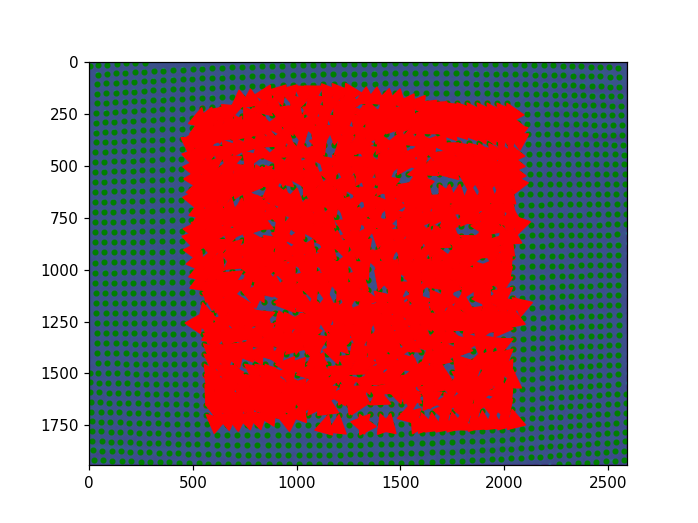

In [50]:
from collections import namedtuple
ErrorMetric = namedtuple("ErrorMetric",["mean", "median", "min", "max", "std", "count", "sqsum"])
bounds2d2 = [(1000,1800),(800, 1500), (20,100), (-5, 5), (-5, 5), (20,100), 
             (-10, 10),(-10, 10), (None, None), (None, None)]
def extract_points(size=10, precision=40, unwrapf=unwrapd2, param=res12d2u.x):
    all_idx = numpy.array(list(itertools.product(range(-size, size+1),range(-size, size+1)))).astype("float64")
    expected = unwrapf(param, data=all_idx)
    all_dist = cdist(expected, peaks_ref_xy,  'euclidean')
    amin = all_dist.argmin(axis=1)
    dmin = all_dist.min(axis=1)
    msk = dmin < precision
    dataset = numpy.zeros((msk.sum(), 4))
    dataset[:,:2] = all_idx[msk]
    dataset[:,2:] = peaks_ref_xy[amin[msk]]
    return dataset

def mean_error(unwrapf, param, dataset):
    ex = unwrapf(param, data=dataset) 
    di = dataset[:,2:]
    d2 = (ex-di)**2
    dist = numpy.sqrt(numpy.sum(d2, axis=-1))
    res = ErrorMetric(dist.mean(), numpy.median(dist), dist.min(), dist.max(), dist.std(), len(dist), (dist*dist).sum())
    return res

def display_error(unwrapf, param, dataset):
    fitted =  unwrapf(param, data=dataset)
    f,ax = subplots()
    ax.imshow(cnv, interpolation="nearest")
    plot(fitted[:,0], fitted[:,1],".r")
    plot(peaks_ref_xy[:,0],peaks_ref_xy[:, 1], ".g")
    for ds, w in zip(dataset, fitted):
        ax.annotate("", xy=ds[2:], xytext=w,
                    arrowprops=dict(facecolor='red', edgecolor='red'))

dataset_15 = extract_points(15, 40, unwrapd2, res12d2u.x)

print(mean_error(unwrapd2, res12d2u.x, dataset_15))

res15d2u  = minimize(errord2u, res12d2u.x, bounds=bounds2d2, args=(dataset_15,))
print(res15d2u)
print(mean_error(unwrapd2, res15d2u.x, dataset_15))

display_error(unwrapd2, res15d2u.x, dataset_15)


ErrorMetric(mean=0.61889956541138291, median=0.54112982867494608, min=0.021238791714962926, max=2.1780034181502712, std=0.38178843242642169, count=1225, sqsum=647.77887202125316)
      fun: 620.66109460617463
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00944738,  0.00062528, -0.05077254,  0.25298732,  0.06598384,
       -0.20132802,  0.51450115,  0.21120741,  0.01705303,  0.0396426 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1903
      nit: 153
   status: 0
  success: True
        x: array([  1.26306249e+03,   9.61478475e+02,   5.06561697e+01,
         8.17536019e-01,  -7.91438531e-01,   5.07852732e+01,
        -5.85834355e-01,   2.59399453e-01,  -2.84678615e+01,
         1.81733785e+00])
ErrorMetric(mean=0.62351826840600921, median=0.56359664222448402, min=0.02275525133874055, max=2.0614089363829113, std=0.34334689019973463, count=1225, sqsum=620.66109460617463)
Second pass
ErrorMetric(mean=0.62351826840600921, median=

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


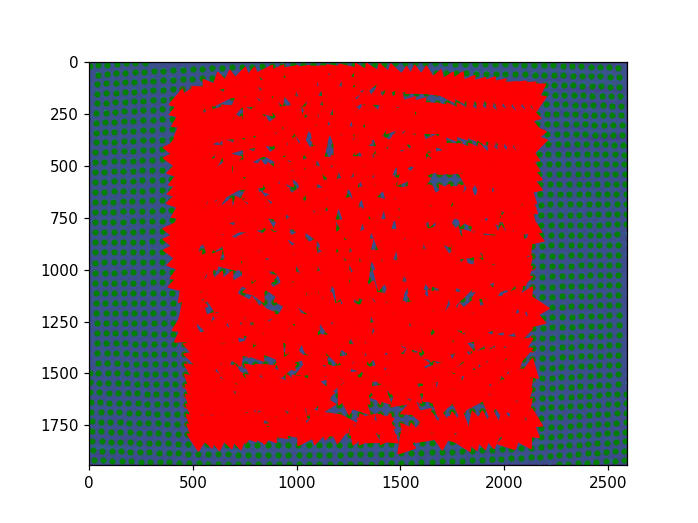

In [51]:
dataset_17 = extract_points(17, 40, unwrapd2, res15d2u.x)

print(mean_error(unwrapd2, res15d2u.x, dataset_17))
res17d2u  = minimize(errord2u, res15d2u.x, bounds=bounds2d2, args=(dataset_17,))
print(res17d2u)
print(mean_error(unwrapd2, res17d2u.x, dataset_17))

print("Second pass")
dataset_17b = extract_points(17, 40, unwrapd2, res17d2u.x)

print(mean_error(unwrapd2, res17d2u.x, dataset_17b))
res17d2ub  = minimize(errord2u, res17d2u.x, bounds=bounds2d2, args=(dataset_17b,))
print(res17d2ub)
print(mean_error(unwrapd2, res17d2ub.x, dataset_17b))
display_error(unwrapd2, res17d2ub.x, dataset_17b)

In [52]:
dataset_20 = extract_points(20, 38, unwrapd2, res17d2ub.x)

print(mean_error(unwrapd2, res17d2ub.x, dataset_20))
res20d2u  = minimize(errord2u, res17d2ub.x, bounds=bounds2d2, args=(dataset_20,))
print(res20d2u)
print(mean_error(unwrapd2, res20d2u.x, dataset_20))


ErrorMetric(mean=0.82099521404917031, median=0.67101244701211205, min=0.022750966590975086, max=3.4428672763633386, std=0.55166833220249201, count=1640, sqsum=1604.5285880046247)
      fun: 1433.3428048583035
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.2115712 ,  0.23298981,  0.48053153,  1.11394911,  0.09797532,
        0.32810021,  1.65116489,  0.179989  ,  0.04908998,  0.07655672])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1001
      nit: 82
   status: 0
  success: True
        x: array([  1.26003557e+03,   9.59189770e+02,   5.06506059e+01,
         8.13772026e-01,  -7.90966582e-01,   5.07748327e+01,
        -6.45347776e-01,   2.16510897e-01,  -2.81377685e+01,
         1.81361910e+00])
ErrorMetric(mean=0.82161901491018408, median=0.74013427392769437, min=0.016941962227183843, max=2.799405439237391, std=0.44601761119435723, count=1640, sqsum=1433.3428048583037)


21: first pass
ErrorMetric(mean=0.8641615321082563, median=0.77005252193491491, min=0.016941962227183843, max=3.7643232800911934, std=0.48912267220071987, count=1723, sqsum=1698.905812728824)
      fun: 1687.4627061738875
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.09868018,  0.41768544,  1.35787559, -0.316777  , -0.53237272,
       -1.1326847 , -0.95078576, -7.82931693,  0.21964297, -0.21987034])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 572
      nit: 47
   status: 0
  success: True
        x: array([  1.26000929e+03,   9.58644101e+02,   5.06427874e+01,
         8.13218254e-01,  -7.90182285e-01,   5.07661738e+01,
        -6.45708561e-01,   2.06667673e-01,  -2.77380513e+01,
         1.61370457e+00])
ErrorMetric(mean=0.86939367458732408, median=0.79418665630616569, min=0.015246416019541438, max=3.3835533808479474, std=0.47278895451138925, count=1723, sqsum=1687.4627061738875)


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


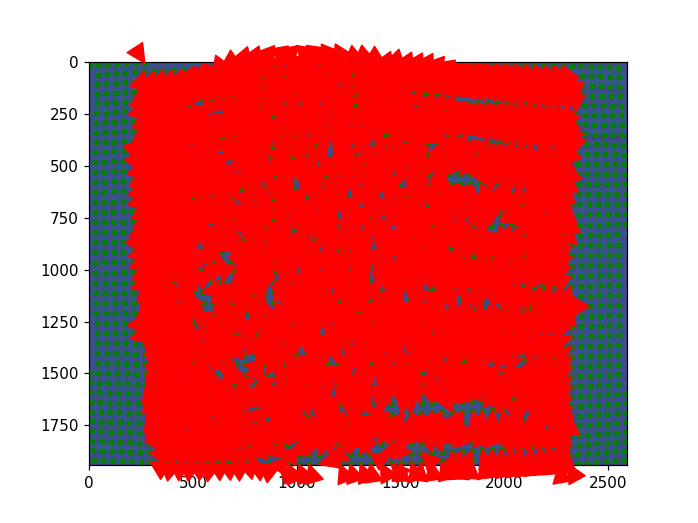

In [53]:
print("21: first pass")
dataset_21 = extract_points(21, 38, unwrapd2, res20d2u.x)

print(mean_error(unwrapd2, res20d2u.x, dataset_21))
res21d2u  = minimize(errord2u, res20d2u.x, bounds=bounds2d2, args=(dataset_21,))
print(res21d2u)
print(mean_error(unwrapd2, res21d2u.x, dataset_21))

# print("21: second pass")
# dataset_21b = extract_points(21, 30, unwrapd2, res21d2u.x)
# print(mean_error(unwrapd2, res21d2u.x, dataset_21b))
# res21d2ub  = minimize(errord2u, res21d2u.x, bounds=bounds2d2, args=(dataset_21b,))
# print(res21d2ub)
# print(mean_error(unwrapd2, res21d2ub.x, dataset_21b))

display_error(unwrapd2, res21d2u.x, dataset_21)

25: first pass
ErrorMetric(mean=1.0611626663920417, median=0.88263018705111873, min=0.015246416019541438, max=4.5309073750683231, std=0.65750476108378808, count=2051, sqsum=3196.234745269232)
      fun: 2988.7469633191295
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.77143341,  0.10882104, -0.19554136,  0.14897523, -0.08390089,
       -1.11886038, -0.75583557,  1.35096343, -0.15843398, -0.32441676])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 869
      nit: 71
   status: 0
  success: True
        x: array([  1.26037445e+03,   9.56585077e+02,   5.06350892e+01,
         8.11267862e-01,  -7.86257395e-01,   5.07558757e+01,
        -6.37570956e-01,   1.70106861e-01,  -2.74429558e+01,
         1.56247349e+00])
ErrorMetric(mean=1.0611626663920417, median=0.88263018705111873, min=0.015246416019541438, max=4.5309073750683231, std=0.65750476108378808, count=2051, sqsum=3196.234745269232)


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


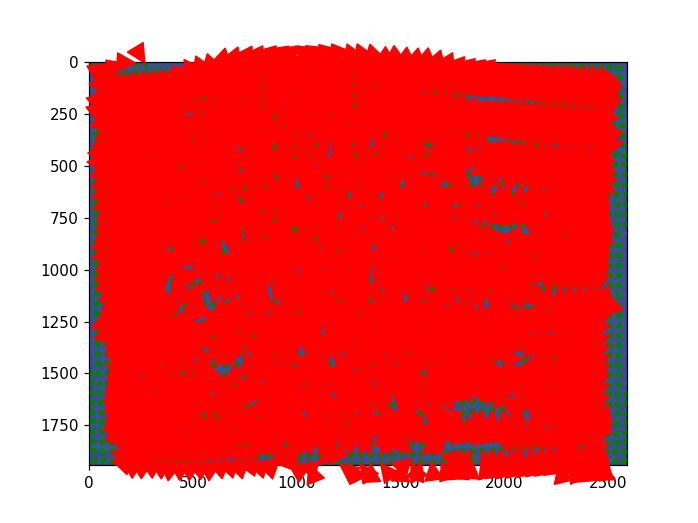

In [54]:
print("25: first pass")
dataset_25 = extract_points(25, 38, unwrapd2, res21d2u.x)

print(mean_error(unwrapd2, res21d2u.x, dataset_25))
res25d2u  = minimize(errord2u, res21d2u.x, bounds=bounds2d2, args=(dataset_25,))
print(res25d2u)
print(mean_error(unwrapd2, res21d2u.x, dataset_25))

# print("22: second pass")
# dataset_22b = extract_points(22, 30, unwrapd2, res22d2u.x)
# print(mean_error(unwrapd2, res22d2u.x, dataset_22b))
# res22d2ub  = minimize(errord2u, res22d2u.x, bounds=bounds2d2, args=(dataset_22b,))
# print(res22d2ub)
# print(mean_error(unwrapd2, res22d2ub.x, dataset_22b))

display_error(unwrapd2, res25d2u.x, dataset_25)



Extract 28 shells
ErrorMetric(mean=1.1407982243013211, median=1.0022374844642641, min=0.010389810605001952, max=6.4582883843643808, std=0.65827511402872807, count=2169, sqsum=3762.6656233570056)
      fun: 3735.4974640507317
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.32359821,  0.03310561,  0.23701432,  0.67720975, -0.07239578,
       -0.16143531,  0.5145921 ,  0.53751137,  0.02082743,  0.07389644])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 792
      nit: 63
   status: 0
  success: True
        x: array([  1.26027091e+03,   9.55827127e+02,   5.06336506e+01,
         8.10183707e-01,  -7.86779564e-01,   5.07539023e+01,
        -6.39294396e-01,   1.56555827e-01,  -2.74031062e+01,
         1.56478001e+00])
ErrorMetric(mean=1.1496729380536204, median=1.0363888630278719, min=0.034418782410562357, max=6.5710602777612754, std=0.6328295098605714, count=2169, sqsum=3735.4974640507317)


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


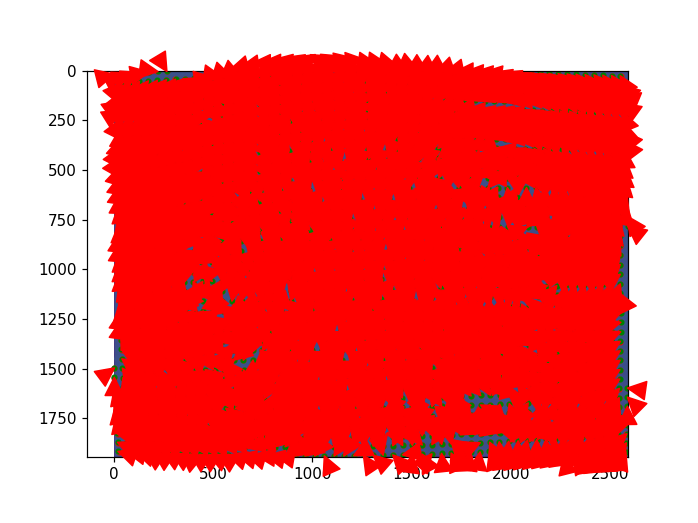

In [55]:
def fit_range(size, precision, function, old_param):
    def error(param, dataset):
        ex = function(param, dataset) 
        di = dataset[:,2:]
        delta2 = (ex-di)**2
        return delta2.sum()

    print("Extract %i shells"%size)
    dataset = extract_points(size, precision, function, old_param)
    print(mean_error(function, old_param, dataset))
    bounds = bounds2d2 + [(None, None)]*(len(old_param)-len(bounds2d2))
    fitted = minimize(error, old_param, bounds=bounds, args=(dataset,))
    print(fitted)
    print(mean_error(function, fitted.x, dataset))
    display_error(function, fitted.x, dataset)
    return fitted.x

fit_28 = fit_range(28, 35, unwrapd2, numpy.array(res25d2u.x))


Extract 28 shells
ErrorMetric(mean=1.1496729380536204, median=1.0363888630278719, min=0.034418782410562357, max=6.5710602777612754, std=0.6328295098605714, count=2169, sqsum=3735.4974640507317)
      fun: 3735.4974633520933
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.27002898,  0.08808456,  0.15588739,  0.51968527,  0.01396074,
       -0.10040822, -2.02180672, -2.20529728,  0.01850822,  0.07680683,
        1.31531124])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 36
      nit: 1
   status: 0
  success: True
        x: array([  1.26027091e+03,   9.55827127e+02,   5.06336505e+01,
         8.10183372e-01,  -7.86779528e-01,   5.07539024e+01,
        -6.39294650e-01,   1.56555561e-01,  -2.74031062e+01,
         1.56477997e+00,  -6.50337248e-07])
ErrorMetric(mean=1.149670639749375, median=1.0363740250997417, min=0.034433521023058189, max=6.571042921213806, std=0.6328336849594649, count=2169, sqsum=3735.4974633520942)


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


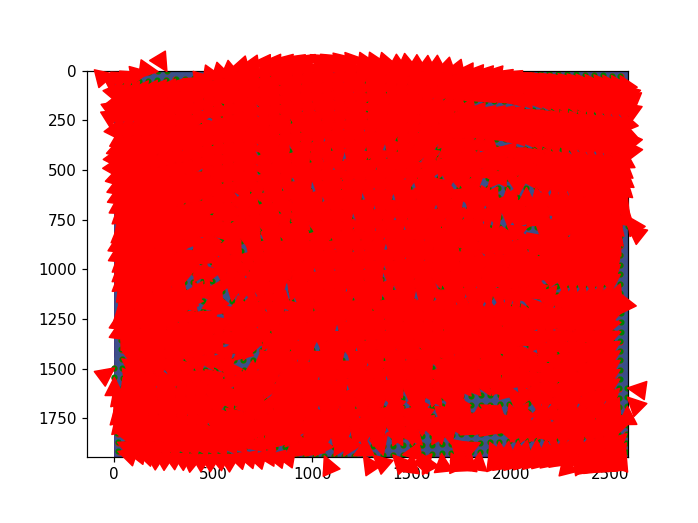

In [56]:
def unwrapd3(arg, data=dataset):
    "convert indexes to distorted position"
    u = rotate(arg[:8], data=data) 
    c = numpy.atleast_2d(numpy.array((arg[0], arg[1])))
    r1 =((u - c)**2).sum(axis=-1)
    r2 = numpy.atleast_2d(r1).T
    #for i in zip(dataset, r2, range(10)):
    #    print(i[0], i[1])
    K1 = arg[8]*1e-9
    K2 = arg[9]*1e-15
    K3 = arg[10]*1e-23
    return c + (u - c)*(1.0 + K1*r2 + K2*r2*r2 + K3*r2*r2*r2)
fit_29 = fit_range(28, 35, unwrapd3, list(fit_28) +[0.0])

In [58]:
def correct2(coord, arg=fit_28):
    "convert position to distorted position"
    c0, c1 = arg[:2]
    u0, u1 = coord
    r2 =(c0 - u0)**2 + (c1 - u1)**2
    K1 = arg[8]*1e-9
    K2 = arg[9]*1e-15
    cor = (1.0+K1*r2+K2*r2*r2)
    return (c0 + (u0 - c0)*cor, c1 + (u1 - c1)*cor)

def correct3(coord, arg=fit_29):
    "convert indexes to distorted position"
    center = numpy.atleast_2d(arg[:2])
    delta = coord - center
    dist2 = (dist**2).sum(axis=-1)
    K1 = arg[8]*1e-9
    K2 = arg[9]*1e-15
    K3 = arg[10]*1e-23
    correction = (1.0 + K1*dist2 + K2*dist2*dist2 + K3*dist2*dist2*dist2)
    return (center+delta/(numpy.atleast_2d(correction).T))


In [64]:
print(fit_29)
corners = numpy.array([[0.0,0.0],[img.shape[0],0.0],[img.shape[0],img.shape[1]],[0.0, img.shape[1]]], dtype="float64")
print(img.shape)
#print(correct3(corners))
center = numpy.atleast_2d([fit_29[0],  fit_29[1] ])
coord = numpy.atleast_2d(corners)
delta = coord - center
dist2 = (delta**2).sum(axis=-1)
print(dist2)
K1 = fit_29[8]*1e-9
K2 = fit_29[9]*1e-15
K3 = fit_29[10]*1e-23
correction = (1.0 + K1*dist2 + K2*dist2*dist2 + K3*dist2*dist2*dist2)
print(correction)
limits = (center+delta/(numpy.atleast_2d(correction).T))
print(limits)
limits.max(axis=0)-limits.min(axis=0)

[  1.26027091e+03   9.55827127e+02   5.06336505e+01   8.10183372e-01
  -7.86779528e-01   5.07539024e+01  -6.39294650e-01   1.56555561e-01
  -2.74031062e+01   1.56477997e+00  -6.50337248e-07]
(1944, 2592)
[ 2501888.25556945  1381090.9701017   3144547.14252828  4265344.42799603]
[ 0.94123514  0.9651385   0.92930246  0.91158461]
[[  -78.68346033   -59.67588829]
 [ 1968.69679041   -34.52516861]
 [ 1996.01531905  2716.47335478]
 [ -122.23477903  2750.69383993]]


array([ 2118.25009808,  2810.36972822])

In [85]:
from collections import OrderedDict
res = OrderedDict()
res["center_x"] = fit_29[0]
res["center_y"] = fit_29[1]
res["K1"] = fit_29[8]*1e-9
res["K2"] = fit_29[9]*1e-15
res["K3"] = fit_29[10]*1e-23
import json
with open("RPI_cam_v1_CS-lens_3.8mm.json", "w") as f:
    f.write(json.dumps(res, indent=4))


In [77]:
H_inter = 65
V_inter = 49
dist = 940 #mm
pitch = 0.5*(1092./65 + 825./49)
print(1092./65, 825./49, pitch)

16.8 16.836734693877553 16.81836734693878


In [73]:
dataset = extract_points(30, 30, unwrapd3, fit_29)
print("x", dataset[:,0].min(), dataset[:,0].max())
print("y", dataset[:,1].min(), dataset[:,1].max())
dx = 0.5*(27+27)*pitch #half opening  horizontal
dy = 0.5*(21+20)*pitch #half opening vertical
op_x = numpy.arctan2(dx, 940)
op_y = numpy.arctan2(dy, 940)

x -27.0 27.0
y -20.0 21.0


In [74]:
print(degrees(op_x)*2)
print(degrees(op_y)*2)

51.5685892312
40.2844122462


In [75]:
numpy.array((1944, 2592))*1.4e-3

array([ 2.7216,  3.6288])

In [84]:
dx_2 = 3.76/2 
dy_2 = 2.74/2
f_x = dx_2*940/dx
f_y = dy_2*940/dy
print(f_x, f_y)

3.891688800801772 3.735173034293138


In [78]:
print(dx)

454.095918367347


In [82]:
fx = 0.5*3.76/tan(op_x)
fy = 0.5*2.74/tan(op_y)
print(fx,fy)

3.8916888008 3.73517303429


In [88]:
from collections import OrderedDict
res = OrderedDict()
res["center_x"] = fit_29[0]
res["center_y"] = fit_29[1]
res["focal"] = 0.5*(fx+fy)
res["pixel"] = 0.5*(3.76/2592 + 2.74/1944)
res["K1"] = fit_29[8]*1e-9
res["K2"] = fit_29[9]*1e-15
res["K3"] = fit_29[10]*1e-23

import json
with open("RPI_cam_v1_CS-lens_3.8mm.json", "w") as f:
    f.write(json.dumps(res, indent=4))
print(json.dumps(res, indent=4))

{
    "center_x": 1260.2709067561084,
    "center_y": 955.8271272325265,
    "focal": 3.8134309175474552,
    "pixel": 0.0014300411522633746,
    "K1": -2.740310623233222e-08,
    "K2": 1.5647799727441311e-15,
    "K3": -6.50337247898053e-30
}
